### Kaggle Titanic data set

The score of this competition is accuracy.

In [1]:
import os


os.getcwd()

In [2]:
import zipfile


path_to_zip_file = os.getcwd() + '\\titanic.zip'
directory_to_extract_to = os.getcwd()
with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
    zip_ref.extractall(directory_to_extract_to)

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
from sklearn import metrics
import xgboost
import lightgbm
import catboost
from catboost import CatBoostClassifier, CatBoostRegressor
from warnings import filterwarnings
import pickle
import category_encoders as ce
from sklearn.feature_selection import RFE
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
filterwarnings('ignore')

### Understanding the data

In [4]:
df_samp = pd.read_csv('gender_submission.csv')
df_samp.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [5]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

In [6]:
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [7]:
df_test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [8]:
df_train.isnull().any()

PassengerId    False
Survived       False
Pclass         False
Name           False
Sex            False
Age             True
SibSp          False
Parch          False
Ticket         False
Fare           False
Cabin           True
Embarked        True
dtype: bool

In [9]:
df_train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [10]:
len(df_train)

891

In [11]:
df_test.isnull().any()

PassengerId    False
Pclass         False
Name           False
Sex            False
Age             True
SibSp          False
Parch          False
Ticket         False
Fare            True
Cabin           True
Embarked       False
dtype: bool

In [12]:
df_test.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

In [13]:
len(df_test)

418

### Encoding and data cleaning

In [14]:
for col in df_train.columns:
    print('Feature {} has {} not null unique values of type {}'.format(col, df_train[col].nunique(dropna=True), df_train[col].dtype.name))

Feature PassengerId has 891 not null unique values of type int64
Feature Survived has 2 not null unique values of type int64
Feature Pclass has 3 not null unique values of type int64
Feature Name has 891 not null unique values of type object
Feature Sex has 2 not null unique values of type object
Feature Age has 88 not null unique values of type float64
Feature SibSp has 7 not null unique values of type int64
Feature Parch has 7 not null unique values of type int64
Feature Ticket has 681 not null unique values of type object
Feature Fare has 248 not null unique values of type float64
Feature Cabin has 147 not null unique values of type object
Feature Embarked has 3 not null unique values of type object


We have five categorical features: Name, Sex, Ticket, Cabin and Embarked.

Here we take a closer look at each to decide which one to keep and what type of encoding to apply.

In [15]:
df_train['Ticket'].head()

0           A/5 21171
1            PC 17599
2    STON/O2. 3101282
3              113803
4              373450
Name: Ticket, dtype: object

In [16]:
df_train['Cabin'].head()

0     NaN
1     C85
2     NaN
3    C123
4     NaN
Name: Cabin, dtype: object

In [17]:
df_train['Embarked'].head()

0    S
1    C
2    S
3    S
4    S
Name: Embarked, dtype: object

In [18]:
df_train['Sex'].head()

0      male
1    female
2    female
3    female
4      male
Name: Sex, dtype: object

+ Sex and Embarked have low number of values, therefore, I will apply one-hot encoding on them.
+ Name is not an important factor in making the predictive model. However, we will keep it to check if our hypothesis is true.
+ We will use label encoding for Cabin and Ticket. They both have NA values, therefore it is important to handle them to make sure labelencoder does not assign unique values to NA.
+ To apply the same encoding on both train and test, we will concat them both first, apply the encoders, and split them back.

In [19]:
df_train_drp = df_train.drop('Survived', axis=1)
y = df_train['Survived']
df_train_drp.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [20]:
y.head()

0    0
1    1
2    1
3    1
4    0
Name: Survived, dtype: int64

In [21]:
df_total = pd.concat([df_train_drp, df_test], axis=0, ignore_index=True)

In [22]:
df_total.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [23]:
df_total.isnull().sum()

PassengerId       0
Pclass            0
Name              0
Sex               0
Age             263
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1014
Embarked          2
dtype: int64

**Dataframe test has one null value in feature 'Fare'. We study this feature to decide what encoding to apply.**

In [24]:
df_total['Fare'].nunique(dropna=True)

281

In [25]:
df_total['Fare'].head()

0     7.2500
1    71.2833
2     7.9250
3    53.1000
4     8.0500
Name: Fare, dtype: float64

In [26]:
df_total['Fare'].dtype.name

'float64'

Fare is a floating value. We will use interpolation for training the predictive model.

### Applying encoding to the concatinated dataframe

#### One-hot encoding

In [27]:
sex_col = pd.get_dummies(df_total['Sex'], prefix='Sex')
sex_col

,Sex_female,Sex_male
0,0,1
1,1,0
2,1,0
3,1,0
4,0,1
...,...,...
1304,0,1
1305,1,0
1306,0,1
1307,0,1


In [28]:
embarked_col = pd.get_dummies(df_total['Embarked'], dummy_na=True, prefix='Embarked')
embarked_col

,Embarked_C,Embarked_Q,Embarked_S,Embarked_nan
0,0,0,1,0
1,1,0,0,0
2,0,0,1,0
3,0,0,1,0
4,0,0,1,0
...,...,...,...,...
1304,0,0,1,0
1305,1,0,0,0
1306,0,0,1,0
1307,0,0,1,0


In [29]:
embarked_col[embarked_col['Embarked_nan']==1]

,Embarked_C,Embarked_Q,Embarked_S,Embarked_nan
61,0,0,0,1
829,0,0,0,1


#### Applying lable encoder

In applying lable encoder we must be sure null values are not assigned any numbers. For this we can use either of the two following approaches:

1. Apply label encoder only to str values.
2. Make a pandas series and only apply label encoder to not null values. This requires reconstrucitng the dataframe by keeping the index values as well.

In [30]:
df_total['Cabin']

0        NaN
1        C85
2        NaN
3       C123
4        NaN
        ... 
1304     NaN
1305    C105
1306     NaN
1307     NaN
1308     NaN
Name: Cabin, Length: 1309, dtype: object

In [31]:
# le = LabelEncoder()
# df_total['Cabin'] = df_total['Cabin'].map(lambda x: le.fit_transform([x])[0] if type(x)==str else x)
# le.transform([x])[0] outout is numpy array. Each will be a single value in an array. Therefore, [0].

In [32]:
# df_total['Cabin'].head()

In [33]:
df_total['Ticket']

0                A/5 21171
1                 PC 17599
2         STON/O2. 3101282
3                   113803
4                   373450
               ...        
1304             A.5. 3236
1305              PC 17758
1306    SOTON/O.Q. 3101262
1307                359309
1308                  2668
Name: Ticket, Length: 1309, dtype: object

In [34]:
df_total['Ticket'].isnull().sum()

0

In [35]:
le_ticket = LabelEncoder()
df_total['Ticket'] = le_ticket.fit_transform(df_total['Ticket'])

In [36]:
df_total['Ticket']

0       720
1       816
2       914
3        65
4       649
       ... 
1304    711
1305    834
1306    872
1307    579
1308    262
Name: Ticket, Length: 1309, dtype: int32

#### The other way to apply label encoding while keeping null values

In [37]:
# le_cabin_2 = LabelEncoder()
# series = df_total['Cabin'].apply(str)
# series = pd.Series(
#     data= le_cabin_2.fit_transform(series[series.notnull()]]),
#     index = series[series.notnull()].index
# )
# series
label_encoder = LabelEncoder()
series = df_total['Cabin'].apply(str)
df_total['Cabin'] = pd.Series(
    label_encoder.fit_transform(series[series.notnull()]),
    index=series[series.notnull()].index
)

In [38]:
df_total['Cabin'].head()
# NA is 186

0    186
1    106
2    186
3     70
4    186
Name: Cabin, dtype: int32

#### Encoding Name

Name should not have any impact on the survival probability of a passanger. To check this hypothesis, we encode name as well to make sure we are right.

On one condition name can have an impact on survival rate and that is if there is some type of racism going on that reduces the chance of let's say minorities to survive. We will check this if it plays a role.


For name we apply catboost encoder

In [39]:
# cat_features = ['Name']
# cat_enc = ce.CatBoostEncoder(cols=cat_features)

# cat_enc.fit_transform( df_tota)

# train = train.join(target_enc.transform(train[cat_features]).add_suffix('_cb'))

In [40]:
le_name = LabelEncoder()
df_total['Name'] = le_name.fit_transform(df_total['Name'])

In [41]:
df_total.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,3,155,male,22.0,1,0,720,7.2500,186,S
1,2,1,286,female,38.0,1,0,816,71.2833,106,C
2,3,3,523,female,26.0,0,0,914,7.9250,186,S
3,4,1,422,female,35.0,1,0,65,53.1000,70,S
4,5,3,22,male,35.0,0,0,649,8.0500,186,S


In [42]:
# df_total.drop(['Cabin2', 'Ticket2'], axis=1, inplace=True)

In [43]:
# df_total.head()

In [44]:
df_t_sex = pd.concat([df_total, sex_col], axis=1)
df_t_sex.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Sex_female,Sex_male
0,1,3,155,male,22.0,1,0,720,7.2500,186,S,0,1
1,2,1,286,female,38.0,1,0,816,71.2833,106,C,1,0
2,3,3,523,female,26.0,0,0,914,7.9250,186,S,1,0
3,4,1,422,female,35.0,1,0,65,53.1000,70,S,1,0
4,5,3,22,male,35.0,0,0,649,8.0500,186,S,0,1


In [45]:
df_final = pd.concat([df_t_sex, embarked_col], axis = 1)
df_final.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Embarked_nan
0,1,3,155,male,22.0,1,0,720,7.2500,186,S,0,1,0,0,1,0
1,2,1,286,female,38.0,1,0,816,71.2833,106,C,1,0,1,0,0,0
2,3,3,523,female,26.0,0,0,914,7.9250,186,S,1,0,0,0,1,0
3,4,1,422,female,35.0,1,0,65,53.1000,70,S,1,0,0,0,1,0
4,5,3,22,male,35.0,0,0,649,8.0500,186,S,0,1,0,0,1,0


In [46]:
df_final.drop(['Sex', 'Embarked'], axis=1, inplace=True)
df_final.head()

,PassengerId,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Embarked_nan
0,1,3,155,22.0,1,0,720,7.2500,186,0,1,0,0,1,0
1,2,1,286,38.0,1,0,816,71.2833,106,1,0,1,0,0,0
2,3,3,523,26.0,0,0,914,7.9250,186,1,0,0,0,1,0
3,4,1,422,35.0,1,0,65,53.1000,70,1,0,0,0,1,0
4,5,3,22,35.0,0,0,649,8.0500,186,0,1,0,0,1,0


In [47]:
y.head()

0    0
1    1
2    1
3    1
4    0
Name: Survived, dtype: int64

In [48]:
len(df_train)

891

In [49]:
len(df_test)

418

In [50]:
df_train_enc = df_final.iloc[:len(df_train)]
df_train_enc.head()

,PassengerId,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Embarked_nan
0,1,3,155,22.0,1,0,720,7.2500,186,0,1,0,0,1,0
1,2,1,286,38.0,1,0,816,71.2833,106,1,0,1,0,0,0
2,3,3,523,26.0,0,0,914,7.9250,186,1,0,0,0,1,0
3,4,1,422,35.0,1,0,65,53.1000,70,1,0,0,0,1,0
4,5,3,22,35.0,0,0,649,8.0500,186,0,1,0,0,1,0


In [51]:
df_test_enc = df_final.iloc[len(df_train):]
df_test_enc.head()

,PassengerId,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Embarked_nan
891,892,3,638,34.5,0,0,376,7.8292,186,0,1,0,1,0,0
892,893,3,1266,47.0,1,0,582,7.0000,186,1,0,0,0,1,0
893,894,2,837,62.0,0,0,184,9.6875,186,0,1,0,1,0,0
894,895,3,1278,27.0,0,0,366,8.6625,186,0,1,0,0,1,0
895,896,3,543,22.0,1,1,338,12.2875,186,1,0,0,0,1,0


### Feature Selection

In [52]:
## Using recursive feature elimination
from sklearn.feature_selection import RFE
from xgboost import XGBClassifier

In [53]:
xgb_model = XGBClassifier(random_state=2020, n_estimators=2000, max_depth=8, colsample_bytree=0.85, missing=None,n_jobs=5,
                          scale_pos_weight=0.1, learning_rate=0.008, reg_alpha=2.01, reg_lambda=0.05, verbosity=1)
selector = RFE(xgb_model, n_features_to_select=8, step=1)
selector = selector.fit(df_train_enc, y)
selector.support_
# selector.ranking_

[12:30:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:30:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:30:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:30:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

array([False,  True,  True,  True, False, False,  True,  True,  True,
        True,  True, False, False, False, False])

In [54]:
selector.ranking_

array([3, 1, 1, 1, 7, 6, 1, 1, 1, 1, 1, 2, 4, 5, 8])

In [55]:
df_train_enc.columns

Index(['PassengerId', 'Pclass', 'Name', 'Age', 'SibSp', 'Parch', 'Ticket',
       'Fare', 'Cabin', 'Sex_female', 'Sex_male', 'Embarked_C', 'Embarked_Q',
       'Embarked_S', 'Embarked_nan'],
      dtype='object')

In [56]:
[item for item in zip(df_train_enc.columns, selector.support_)]

[('PassengerId', False),
 ('Pclass', True),
 ('Name', True),
 ('Age', True),
 ('SibSp', False),
 ('Parch', False),
 ('Ticket', True),
 ('Fare', True),
 ('Cabin', True),
 ('Sex_female', True),
 ('Sex_male', True),
 ('Embarked_C', False),
 ('Embarked_Q', False),
 ('Embarked_S', False),
 ('Embarked_nan', False)]

In [57]:
selector.get_params()

{'estimator__objective': 'binary:logistic',
 'estimator__use_label_encoder': True,
 'estimator__base_score': None,
 'estimator__booster': None,
 'estimator__colsample_bylevel': None,
 'estimator__colsample_bynode': None,
 'estimator__colsample_bytree': 0.85,
 'estimator__gamma': None,
 'estimator__gpu_id': None,
 'estimator__importance_type': 'gain',
 'estimator__interaction_constraints': None,
 'estimator__learning_rate': 0.008,
 'estimator__max_delta_step': None,
 'estimator__max_depth': 8,
 'estimator__min_child_weight': None,
 'estimator__missing': None,
 'estimator__monotone_constraints': None,
 'estimator__n_estimators': 2000,
 'estimator__n_jobs': 5,
 'estimator__num_parallel_tree': None,
 'estimator__random_state': 2020,
 'estimator__reg_alpha': 2.01,
 'estimator__reg_lambda': 0.05,
 'estimator__scale_pos_weight': 0.1,
 'estimator__subsample': None,
 'estimator__tree_method': None,
 'estimator__validate_parameters': None,
 'estimator__verbosity': 1,
 'estimator': XGBClassifier(

In [58]:
xgb_model = XGBClassifier(random_state=2020, n_estimators=2000, max_depth=8, colsample_bytree=0.85, missing=None,n_jobs=5,
                          scale_pos_weight=0.1, learning_rate=0.008, reg_alpha=2.01, reg_lambda=0.05, verbosity=1)
selector = RFE(xgb_model, n_features_to_select=2, step=10)
selector = selector.fit(df_train_enc, y)
[item for item in zip(df_train_enc.columns, selector.support_)]

[12:30:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:31:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:31:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[('PassengerId', False),
 ('Pclass', True),
 ('Name', False),
 ('Age', False),
 ('SibSp', False),
 ('Parch', False),
 ('Ticket', False),
 ('Fare', False),
 ('Cabin', False),
 ('Sex_female', False),
 ('Sex_male', True),
 ('Embarked_C', False),
 ('Embarked_Q', False),
 ('Embarked_S', False),
 ('Embarked_nan', False)]

#### As expected PassengerId and Name are not features having impact on target value.

#### One-hot encoding is not a proper way to determine important features, as it creates a lot of extra features.

<div style='color:blue'>
Interestingly taking the first two important features on one-hot encoded data will return Sex_male but not Sex_female. This means sex was an important factor in survival rate, and if you were male it would play a role in surviving or not. But if you were female your survival rate would be insensitive to your gender. Let's check this hypothesis.</div>

In [59]:
df_train.head(2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C


In [60]:
df_train[['Sex', 'Survived']].groupby(by='Sex').mean()

,Survived
Sex,
female,0.742038
male,0.188908


**In train data set on average 74% of female passangers survived, while this value was only 18% for males.**

### Using lable encoding on XGBoost for feature selection

In [61]:
df_total.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,3,155,male,22.0,1,0,720,7.2500,186,S
1,2,1,286,female,38.0,1,0,816,71.2833,106,C
2,3,3,523,female,26.0,0,0,914,7.9250,186,S
3,4,1,422,female,35.0,1,0,65,53.1000,70,S
4,5,3,22,male,35.0,0,0,649,8.0500,186,S


In [62]:
for col in df_total.columns:
    print('Feature {} is of type {}'.format(col, df_total[col].dtype))

Feature PassengerId is of type int64
Feature Pclass is of type int64
Feature Name is of type int32
Feature Sex is of type object
Feature Age is of type float64
Feature SibSp is of type int64
Feature Parch is of type int64
Feature Ticket is of type int32
Feature Fare is of type float64
Feature Cabin is of type int32
Feature Embarked is of type object


In [63]:
for col in df_total.columns:
    if df_total[col].dtype == 'object':
        df_total[col] = df_total[col].apply(str)
        le = LabelEncoder()
        df_total[col+'_le'] = le.fit_transform(df_total[col])

In [64]:
for col in df_total.columns:
    print('Feature {} is of type {}'.format(col, df_total[col].dtype))

Feature PassengerId is of type int64
Feature Pclass is of type int64
Feature Name is of type int32
Feature Sex is of type object
Feature Age is of type float64
Feature SibSp is of type int64
Feature Parch is of type int64
Feature Ticket is of type int32
Feature Fare is of type float64
Feature Cabin is of type int32
Feature Embarked is of type object
Feature Sex_le is of type int32
Feature Embarked_le is of type int32


In [65]:
df_total.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Sex_le,Embarked_le
0,1,3,155,male,22.0,1,0,720,7.2500,186,S,1,2
1,2,1,286,female,38.0,1,0,816,71.2833,106,C,0,0
2,3,3,523,female,26.0,0,0,914,7.9250,186,S,0,2
3,4,1,422,female,35.0,1,0,65,53.1000,70,S,0,2
4,5,3,22,male,35.0,0,0,649,8.0500,186,S,1,2


In [66]:
df_total_le = df_total.drop(['Sex', 'Embarked'], axis=1)

### Applying RFE to label-encoded dataframe

In [67]:
df_train_le_enc = df_total_le.iloc[:len(df_train)]
df_test_le_enc = df_total_le.iloc[len(df_train):]

In [68]:
len(df_train_le_enc)

891

In [69]:
len(df_test_le_enc)

418

In [70]:
df_train_le_enc.head(2)

,PassengerId,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,Sex_le,Embarked_le
0,1,3,155,22.0,1,0,720,7.2500,186,1,2
1,2,1,286,38.0,1,0,816,71.2833,106,0,0


In [71]:
xgb_model = XGBClassifier(random_state=2020, n_estimators=2000, max_depth=8, colsample_bytree=0.85, missing=None,n_jobs=5,
                          scale_pos_weight=0.1, learning_rate=0.008, reg_alpha=2.01, reg_lambda=0.05, verbosity=1)
selector = RFE(xgb_model, n_features_to_select=1, step=1)
selector = selector.fit(df_train_le_enc, y)
[item for item in zip(df_train_le_enc.columns, selector.support_)]

[12:31:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:31:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:31:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:31:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[('PassengerId', False),
 ('Pclass', False),
 ('Name', False),
 ('Age', False),
 ('SibSp', False),
 ('Parch', False),
 ('Ticket', False),
 ('Fare', False),
 ('Cabin', False),
 ('Sex_le', True),
 ('Embarked_le', False)]

#### 2 most important features

In [72]:
xgb_model = XGBClassifier(random_state=2020, n_estimators=2000, max_depth=8, colsample_bytree=0.85, missing=None,n_jobs=5,
                          scale_pos_weight=0.1, learning_rate=0.008, reg_alpha=2.01, reg_lambda=0.05, verbosity=1)
selector = RFE(xgb_model, n_features_to_select=2, step=1)
selector = selector.fit(df_train_le_enc, y)
[item for item in zip(df_train_le_enc.columns, selector.support_)]

[12:31:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:31:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:31:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:31:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[('PassengerId', False),
 ('Pclass', True),
 ('Name', False),
 ('Age', False),
 ('SibSp', False),
 ('Parch', False),
 ('Ticket', False),
 ('Fare', False),
 ('Cabin', False),
 ('Sex_le', True),
 ('Embarked_le', False)]

#### 3 most important features

In [73]:
xgb_model = XGBClassifier(random_state=2020, n_estimators=2000, max_depth=8, colsample_bytree=0.85, missing=None,n_jobs=5,
                          scale_pos_weight=0.1, learning_rate=0.008, reg_alpha=2.01, reg_lambda=0.05, verbosity=0)
selector = RFE(xgb_model, n_features_to_select=3, step=1, verbose=0)
selector = selector.fit(df_train_le_enc, y)
[item for item in zip(df_train_le_enc.columns, selector.support_)]

[('PassengerId', False),
 ('Pclass', True),
 ('Name', False),
 ('Age', False),
 ('SibSp', False),
 ('Parch', False),
 ('Ticket', False),
 ('Fare', False),
 ('Cabin', True),
 ('Sex_le', True),
 ('Embarked_le', False)]

#### 5 most important features

In [74]:
xgb_model = XGBClassifier(random_state=2020, n_estimators=2000, max_depth=8, colsample_bytree=0.85, missing=None,n_jobs=5,
                          scale_pos_weight=0.1, learning_rate=0.008, reg_alpha=2.01, reg_lambda=0.05, verbosity=0)
selector = RFE(xgb_model, n_features_to_select=5, step=1, verbose=0)
selector = selector.fit(df_train_le_enc, y)
selector.support_

array([False,  True, False, False, False, False,  True,  True,  True,
        True, False])

In [75]:
[item for item in zip(df_train_le_enc.columns, selector.support_)]

[('PassengerId', False),
 ('Pclass', True),
 ('Name', False),
 ('Age', False),
 ('SibSp', False),
 ('Parch', False),
 ('Ticket', True),
 ('Fare', True),
 ('Cabin', True),
 ('Sex_le', True),
 ('Embarked_le', False)]

In [76]:
xgb_model = XGBClassifier(random_state=2020, n_estimators=2000, max_depth=8, colsample_bytree=0.85, missing=None,n_jobs=5,
                          scale_pos_weight=0.1, learning_rate=0.008, reg_alpha=2.01, reg_lambda=0.05, verbosity=1)
selector = RFE(xgb_model, n_features_to_select=8, step=1)
selector = selector.fit(df_train_le_enc, y)
selector.support_

[12:31:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:31:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:31:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:31:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

array([False,  True,  True,  True, False, False,  True,  True,  True,
        True,  True])

In [77]:
[item for item in zip(df_train_le_enc.columns, selector.support_)]

[('PassengerId', False),
 ('Pclass', True),
 ('Name', True),
 ('Age', True),
 ('SibSp', False),
 ('Parch', False),
 ('Ticket', True),
 ('Fare', True),
 ('Cabin', True),
 ('Sex_le', True),
 ('Embarked_le', True)]

### Comparing selected features by changing algorithm

### Using lightgbm

In [78]:
from lightgbm import LGBMClassifier
import warnings
warnings.filterwarnings('ignore')

In [79]:
lgb = lightgbm.LGBMClassifier(random_state=2020, n_estimators=2000, num_leaves=31, learning_rate=0.011, 
                              colsample_bytree=0.85, max_depth=8, verbose=-1, importance='gain', 
                              silent=True, verbose_eval = -1)
# lgb.verbose=-1
selector = RFE(lgb, n_features_to_select=1, step=1, verbose=0)
selector = selector.fit(df_train_le_enc, y)
[item for item in zip(df_train_le_enc.columns, selector.support_)]

[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] Unknown parameter: importance
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[('PassengerId', False),
 ('Pclass', False),
 ('Name', False),
 ('Age', False),
 ('SibSp', False),
 ('Parch', False),
 ('Ticket', True),
 ('Fare', False),
 ('Cabin', False),
 ('Sex_le', False),
 ('Embarked_le', False)]

#### In XGBoost most important feature was sex. While in Lightgbm it is ticket!

In [80]:
lgb = lightgbm.LGBMClassifier(random_state=2020, n_estimators=2000, num_leaves=31, learning_rate=0.011, 
                              colsample_bytree=0.85, max_depth=8, verbose=-1, importance='gain', 
                              silent=True, verbose_eval = -1)
# lgb.verbose=-1
selector = RFE(lgb, n_features_to_select=2, step=1, verbose=0)
selector = selector.fit(df_train_le_enc, y)
[item for item in zip(df_train_le_enc.columns, selector.support_)]

[('PassengerId', False),
 ('Pclass', False),
 ('Name', True),
 ('Age', False),
 ('SibSp', False),
 ('Parch', False),
 ('Ticket', True),
 ('Fare', False),
 ('Cabin', False),
 ('Sex_le', False),
 ('Embarked_le', False)]

#### Most important features from lgbm perspective are ticket and name!

#### 3 most important features

In [81]:
lgb = lightgbm.LGBMClassifier(random_state=2020, n_estimators=2000, num_leaves=31, learning_rate=0.011, 
                              colsample_bytree=0.85, max_depth=8, verbose=-1, importance='gain', 
                              silent=True, verbose_eval = -1)
# lgb.verbose=-1
selector = RFE(lgb, n_features_to_select=3, step=1)
selector = selector.fit(df_train_le_enc, y)
[item for item in zip(df_train_le_enc.columns, selector.support_)]

[('PassengerId', True),
 ('Pclass', False),
 ('Name', True),
 ('Age', False),
 ('SibSp', False),
 ('Parch', False),
 ('Ticket', True),
 ('Fare', False),
 ('Cabin', False),
 ('Sex_le', False),
 ('Embarked_le', False)]

#### Lgbm has detected ticket, name and passangerId as most important features!!!

This can be imporved by droping these values from the train dataframe. However, it also shows the algorithm is not suitable for this problem

In [82]:
df_train_lgbm = df_train_le_enc.drop(['PassengerId',  'Name', 'Ticket'], axis=1)
df_train_lgbm.head()

,Pclass,Age,SibSp,Parch,Fare,Cabin,Sex_le,Embarked_le
0,3,22.0,1,0,7.2500,186,1,2
1,1,38.0,1,0,71.2833,106,0,0
2,3,26.0,0,0,7.9250,186,0,2
3,1,35.0,1,0,53.1000,70,0,2
4,3,35.0,0,0,8.0500,186,1,2


In [83]:
lgb = lightgbm.LGBMClassifier(random_state=2020, n_estimators=2000, num_leaves=31, learning_rate=0.011, 
                              colsample_bytree=0.85, max_depth=8, verbose=-1, importance='gain', 
                              silent=True, verbose_eval = -1)
selector = RFE(lgb, n_features_to_select=1, step=1)
selector = selector.fit(df_train_lgbm, y)
[item for item in zip(df_train_lgbm.columns, selector.support_)]

[('Pclass', False),
 ('Age', False),
 ('SibSp', False),
 ('Parch', False),
 ('Fare', True),
 ('Cabin', False),
 ('Sex_le', False),
 ('Embarked_le', False)]

#### Even after droping the irrelevant features which were all selected by lgbm as important, still it returns 'Fare' as an important feature! This algorithm is not suitable for this problem!

### Applying catboost and RFE

#### Scenario 1: Applying catboost on already encoded data

In [84]:
from catboost import CatBoostClassifier

In [85]:
cat = CatBoostClassifier(iterations=2000, learning_rate=0.1, depth=5, verbose=0)
selector = RFE(cat, n_features_to_select=1, step=1, verbose=-1)
selector = selector.fit(df_train_le_enc, y)
[item for item in zip(df_train_le_enc.columns, selector.support_)]

[('PassengerId', False),
 ('Pclass', False),
 ('Name', False),
 ('Age', False),
 ('SibSp', False),
 ('Parch', False),
 ('Ticket', True),
 ('Fare', False),
 ('Cabin', False),
 ('Sex_le', False),
 ('Embarked_le', False)]

In [86]:
# using df_train_lgbm instead of df_train_le_enc
cat = CatBoostClassifier(iterations=2000, learning_rate=0.1, depth=5, verbose=0 )
selector = RFE(cat, n_features_to_select=1, step=1, verbose=-1)
selector = selector.fit(df_train_lgbm, y)
[item for item in zip(df_train_le_enc.columns, selector.support_)]

[('PassengerId', False),
 ('Pclass', False),
 ('Name', False),
 ('Age', False),
 ('SibSp', True),
 ('Parch', False),
 ('Ticket', False),
 ('Fare', False)]

<div style='color:red'><li>Why both catboost and lightgbm are choosing ticket as most important feature? (Even cleaning the data didn't resolve this issue!)</li>
<li>How can we interpret their behavior? (Model Interpretability)</li></div>

#### Maybe ticket and cabin are correlated! 

In [87]:
df_train_le_enc.corr()

,PassengerId,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,Sex_le,Embarked_le
PassengerId,1.000000,-0.035144,-0.037882,0.036847,-0.057527,-0.001652,-0.056470,0.012658,-0.034946,0.042939,0.013083
Pclass,-0.035144,1.000000,0.052644,-0.369226,0.083081,0.018443,0.322475,-0.549500,0.682623,0.131900,0.157112
Name,-0.037882,0.052644,1.000000,0.063372,-0.017345,-0.049639,0.049656,-0.048917,0.062609,0.021256,-0.005555
Age,0.036847,-0.369226,0.063372,1.000000,-0.308247,-0.189119,-0.075818,0.096067,-0.252578,0.093254,-0.025252
SibSp,-0.057527,0.083081,-0.017345,-0.308247,1.000000,0.414838,0.079191,0.159651,0.043342,-0.114631,0.066654
Parch,-0.001652,0.018443,-0.049639,-0.189119,0.414838,1.000000,0.019936,0.216225,-0.028329,-0.245489,0.038322
Ticket,-0.056470,0.322475,0.049656,-0.075818,0.079191,0.019936,1.000000,-0.015503,0.244702,0.060416,-0.004259
Fare,0.012658,-0.549500,-0.048917,0.096067,0.159651,0.216225,-0.015503,1.000000,-0.501474,-0.182333,-0.221226
Cabin,-0.034946,0.682623,0.062609,-0.252578,0.043342,-0.028329,0.244702,-0.501474,1.000000,0.095479,0.191471
Sex_le,0.042939,0.131900,0.021256,0.093254,-0.114631,-0.245489,0.060416,-0.182333,0.095479,1.000000,0.104057


#### <div style='color:blue'>There is correlation between Ticket and Pclass and a little correlation to Cabin and Sex. All three are important features in XGBoost. This interprets why both lgbm and catboost are returning Ticket as an important feature. However, still we can't say why they didn't determine sex and PClass as most important features! </div>

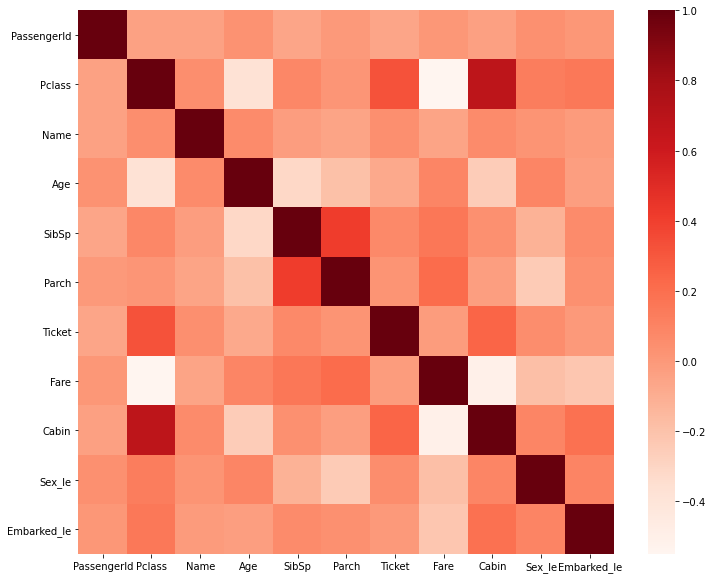

In [88]:
plt.figure(figsize=(12,10))
cor = df_train_le_enc.corr()
# sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
sns.heatmap(cor, cmap=plt.cm.Reds)
plt.show()

#### Scenario 2: Applying catboost on original data set with its own encoding

In [89]:
df_train.head(2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C


In [90]:
df_train_cat = df_train.drop(['PassengerId', 'Name', 'Survived', 'Ticket'], axis = 1)
df_train_cat.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,3,male,22.0,1,0,7.2500,NaN,S
1,1,female,38.0,1,0,71.2833,C85,C
2,3,female,26.0,0,0,7.9250,NaN,S
3,1,female,35.0,1,0,53.1000,C123,S
4,3,male,35.0,0,0,8.0500,NaN,S


In [91]:
df_train_cat.isnull().sum()

Pclass        0
Sex           0
Age         177
SibSp         0
Parch         0
Fare          0
Cabin       687
Embarked      2
dtype: int64

#### Catboost cannot handle null values. All null values must be imputed first.

In [92]:
df_train_cat[df_train_cat['Age'].isnull()]

,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
5,3,male,NaN,0,0,8.4583,NaN,Q
17,2,male,NaN,0,0,13.0000,NaN,S
19,3,female,NaN,0,0,7.2250,NaN,C
26,3,male,NaN,0,0,7.2250,NaN,C
28,3,female,NaN,0,0,7.8792,NaN,Q
...,...,...,...,...,...,...,...,...
859,3,male,NaN,0,0,7.2292,NaN,C
863,3,female,NaN,8,2,69.5500,NaN,S
868,3,male,NaN,0,0,9.5000,NaN,S
878,3,male,NaN,0,0,7.8958,NaN,S


In [93]:
df_train_cat['Age'].mean()

29.69911764705882

In [94]:
df_train_cat['Age'] = df_train_cat['Age'].fillna(df_train_cat['Age'].mean())

In [95]:
df_train_cat.isnull().sum()

Pclass        0
Sex           0
Age           0
SibSp         0
Parch         0
Fare          0
Cabin       687
Embarked      2
dtype: int64

In [96]:
# df_train_cat[df_train_cat['Cabin'].isnull()]
df_train_cat[pd.isnull(df_train_cat['Cabin'])]

,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,3,male,22.000000,1,0,7.2500,NaN,S
2,3,female,26.000000,0,0,7.9250,NaN,S
4,3,male,35.000000,0,0,8.0500,NaN,S
5,3,male,29.699118,0,0,8.4583,NaN,Q
7,3,male,2.000000,3,1,21.0750,NaN,S
...,...,...,...,...,...,...,...,...
884,3,male,25.000000,0,0,7.0500,NaN,S
885,3,female,39.000000,0,5,29.1250,NaN,Q
886,2,male,27.000000,0,0,13.0000,NaN,S
888,3,female,29.699118,1,2,23.4500,NaN,S


In [97]:
df_train_cat.loc[df_train_cat['Cabin'].isnull(), 'Cabin'] = 'Unknown'

In [98]:
df_train_cat.isnull().sum()

Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Cabin       0
Embarked    2
dtype: int64

In [99]:
df_train_cat[df_train_cat['Embarked'].isnull()]

,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
61,1,female,38.0,0,0,80.0,B28,NaN
829,1,female,62.0,0,0,80.0,B28,NaN


In [100]:
df_train_cat['Embarked'].mode()

0    S
dtype: object

In [101]:
df_train_cat['Embarked'] = df_train_cat['Embarked'].fillna(df_train_cat['Embarked'].mode()[0])

In [102]:
df_train_cat.isnull().sum()

Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Cabin       0
Embarked    0
dtype: int64

In [103]:
df_train_cat[df_train_cat['Embarked'].isnull()]

,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked


#### Now data is imputed as follows:

+ Age: Imputed with mean value.
+ Embarked: with mode value.
+ Cabin: Replace NaN with 'Unknown'

In [104]:
df_train_cat.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,3,male,22.0,1,0,7.2500,Unknown,S
1,1,female,38.0,1,0,71.2833,C85,C
2,3,female,26.0,0,0,7.9250,Unknown,S
3,1,female,35.0,1,0,53.1000,C123,S
4,3,male,35.0,0,0,8.0500,Unknown,S


In [105]:
# CatBoostError: Invalid type for cat_feature[non-default value idx=0,feature_idx=6]=nan : cat_features must be integer 
# or string, real number values and NaN values should be converted to string.
cat_features = ['Sex', 'Cabin', 'Embarked']
cat = CatBoostClassifier(iterations=2000, learning_rate=0.1, depth=8, cat_features=cat_features)

In [106]:
# ValueError: could not convert string to float: 'male'
selector = RFE(cat, n_features_to_select=1, step=1, verbose=-1)
selector = selector.fit(df_train_cat, y)
[item for item in zip(df_train_cat.columns, selector.support_)]

ValueError: could not convert string to float: 'male'

## Important lesson: RFE doesn't allow using string values in a model.

Catboost support categrical features directly fed to the algo. But RFE is the component raising error. Therefore, working with scenario 2 doesn't make sence.

In [107]:
for col in df_train_cat.columns:
    if df_train_cat[col].dtype == 'object':
        le = LabelEncoder()
        df_train_cat[col] = le.fit_transform(df_train_cat[col])

In [108]:
df_train_cat.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,3,1,22.0,1,0,7.2500,147,2
1,1,0,38.0,1,0,71.2833,81,0
2,3,0,26.0,0,0,7.9250,147,2
3,1,0,35.0,1,0,53.1000,55,2
4,3,1,35.0,0,0,8.0500,147,2


In [109]:
cat = CatBoostClassifier(iterations=2000, learning_rate=0.1, depth=8, verbose=0)
selector = RFE(cat, n_features_to_select=1, step=1, verbose=-1)
selector = selector.fit(df_train_cat, y)
[item for item in zip(df_train_cat.columns, selector.support_)]

[('Pclass', False),
 ('Sex', False),
 ('Age', False),
 ('SibSp', False),
 ('Parch', False),
 ('Fare', True),
 ('Cabin', False),
 ('Embarked', False)]

### Both catboost and lightgbm select 'Fair' as most important feature in clean data. 

## Select features by calculating feature importance in kfold validation

In [110]:
df_train_le_enc.head()

,PassengerId,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,Sex_le,Embarked_le
0,1,3,155,22.0,1,0,720,7.2500,186,1,2
1,2,1,286,38.0,1,0,816,71.2833,106,0,0
2,3,3,523,26.0,0,0,914,7.9250,186,0,2
3,4,1,422,35.0,1,0,65,53.1000,70,0,2
4,5,3,22,35.0,0,0,649,8.0500,186,1,2


In [111]:

xgb_model = XGBClassifier(random_state=2020, n_estimators=2000, max_depth=8, colsample_bytree=0.85, missing=None,
                          scale_pos_weight=0.1, learning_rate=0.008, reg_alpha=2.01, reg_lambda=0.05, verbosity=1)


# ff1 = []
# ff2 = []
kf = KFold(n_splits=5)
X = df_train_le_enc
importance = []
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]

    xgb_model.fit(X_train, y_train, eval_set=[(X_train, y_train),(X_test, y_test)], verbose=False, early_stopping_rounds=50)
    
    imp = pd.DataFrame({'Importance':xgb_model.feature_importances_,'Feature':X.columns})
    importance.append(imp)

[12:46:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:46:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:46:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:46:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

In [112]:
tmp_df = pd.merge(importance[0], importance[1], left_on='Feature', 
                  right_on='Feature')[['Feature', 'Importance_x', 'Importance_y']]
for i in range(2, len(importance)):
    tmp_df = pd.merge(tmp_df, importance[i], left_on='Feature', 
                      right_on='Feature')


tmp_df['mean'] = tmp_df.mean(axis=1)
tmp_df

,Feature,Importance_x,Importance_y,Importance_x,Importance_y,Importance,mean
0,PassengerId,0.013229,0.016792,0.008602,0.000000,0.007835,0.009292
1,Pclass,0.450204,0.569075,0.414533,0.393774,0.448081,0.455133
2,Name,0.026812,0.007077,0.012315,0.005686,0.018791,0.014136
3,Age,0.025419,0.012197,0.008939,0.007615,0.008659,0.012566
4,SibSp,0.000000,0.000000,0.000970,0.000000,0.007071,0.001608
5,Parch,0.000000,0.000000,0.000000,0.030710,0.005330,0.007208
6,Ticket,0.040218,0.101013,0.065699,0.020874,0.040034,0.053568
7,Fare,0.035832,0.017557,0.041334,0.028335,0.050806,0.034773
8,Cabin,0.145970,0.067013,0.145107,0.203181,0.077913,0.127837
9,Sex_le,0.244023,0.209276,0.284210,0.281963,0.313604,0.266615


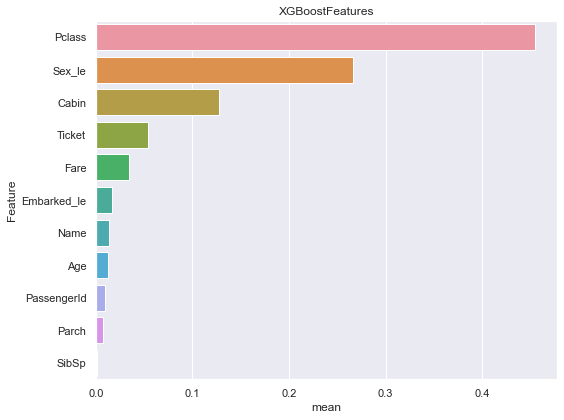

In [113]:

plt.figure(figsize=(8, 6))
sns.set(font_scale = 1)
sns.barplot(x="mean", y="Feature", data=tmp_df.sort_values(by="mean", ascending=False))
plt.title('XGBoostFeatures')
plt.tight_layout()
plt.show()

#### Without kfold by using RFE XGBoost most important feature is 'Sex'; second important feature is PClass and third important feature is Cabin. Using kfold and 'model.feature_importances_' most important feature was PClass, Sex and then Cabin.


**In conclusion, both chose the same set of features, but in different order.**

### Using kfold validation on LGBM

#### Applying on same data of xgboost (uncleaned data with passengerId, name and ticket)

[LightGBM] [Warning] Unknown parameter: importance
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Unknown parameter: importance
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Unknown parameter: importance
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Unknown parameter: importance
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


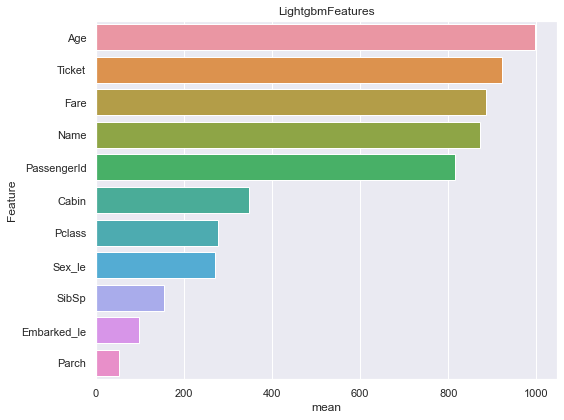

In [114]:
lgb = lightgbm.LGBMClassifier(random_state=2020, n_estimators=2000, num_leaves=31, learning_rate=0.011, 
                              colsample_bytree=0.85, max_depth=5,
                              verbose=-1, class_weight={0:0.2, 1:0.8}, importance='gain')


X = df_train_le_enc
ff1_lgb = []
ff2_lgb = []
kf = KFold(n_splits=5)
importance_lgb = []
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]

    lgb.fit(X_train, y_train, eval_set=[(X_train, y_train),(X_test, y_test)], verbose=False, early_stopping_rounds=10)
    
    imp = pd.DataFrame({'Importance':lgb.feature_importances_,'Feature':X.columns})
    importance_lgb.append(imp)  
    
    pred = lgb.predict(X_test)
    ff1_lgb.append(f1_score(y_test, pred, pos_label=0))
    ff2_lgb.append(f1_score(y_test, pred, pos_label=1))
    

tmp_lgb_df = pd.merge(importance_lgb[0], importance_lgb[1], left_on='Feature', 
                  right_on='Feature')[['Feature', 'Importance_x', 'Importance_y']]
for i in range(2, len(importance_lgb)):
    tmp_lgb_df = pd.merge(tmp_lgb_df, importance_lgb[i], left_on='Feature', 
                      right_on='Feature')

tmp_lgb_df['mean'] = tmp_lgb_df.mean(axis=1)

plt.figure(figsize=(8, 6))
sns.set(font_scale = 1)
sns.barplot(x="mean", y="Feature", data=tmp_lgb_df.sort_values(by="mean", ascending=False))
plt.title('LightgbmFeatures')
plt.tight_layout()
plt.show()



#### Applying on cleaned data for lgbm

In [115]:
df_train_lgbm.head()

,Pclass,Age,SibSp,Parch,Fare,Cabin,Sex_le,Embarked_le
0,3,22.0,1,0,7.2500,186,1,2
1,1,38.0,1,0,71.2833,106,0,0
2,3,26.0,0,0,7.9250,186,0,2
3,1,35.0,1,0,53.1000,70,0,2
4,3,35.0,0,0,8.0500,186,1,2


[LightGBM] [Warning] Unknown parameter: importance
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Unknown parameter: importance
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Unknown parameter: importance
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Unknown parameter: importance
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Unknown parameter: importance
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


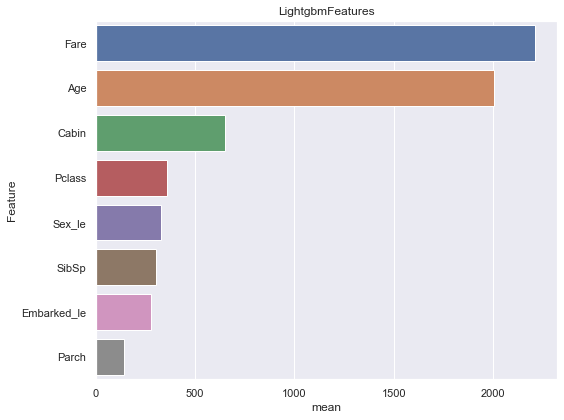

In [116]:
lgb = lightgbm.LGBMClassifier(random_state=2020, n_estimators=2000, num_leaves=31, learning_rate=0.011, 
                              colsample_bytree=0.85, max_depth=5,
                              verbose=-1, class_weight={0:0.2, 1:0.8}, importance='gain')


X = df_train_lgbm
ff1_lgb = []
ff2_lgb = []
kf = KFold(n_splits=5)
importance_lgb = []
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]

    lgb.fit(X_train, y_train, eval_set=[(X_train, y_train),(X_test, y_test)], verbose=False, early_stopping_rounds=10)
    
    imp = pd.DataFrame({'Importance':lgb.feature_importances_,'Feature':X.columns})
    importance_lgb.append(imp)  
    
    pred = lgb.predict(X_test)
    ff1_lgb.append(f1_score(y_test, pred, pos_label=0))
    ff2_lgb.append(f1_score(y_test, pred, pos_label=1))
    

tmp_lgb_df = pd.merge(importance_lgb[0], importance_lgb[1], left_on='Feature', 
                  right_on='Feature')[['Feature', 'Importance_x', 'Importance_y']]
for i in range(2, len(importance_lgb)):
    tmp_lgb_df = pd.merge(tmp_lgb_df, importance_lgb[i], left_on='Feature', 
                      right_on='Feature')

tmp_lgb_df['mean'] = tmp_lgb_df.mean(axis=1)

plt.figure(figsize=(8, 6))
sns.set(font_scale = 1)
sns.barplot(x="mean", y="Feature", data=tmp_lgb_df.sort_values(by="mean", ascending=False))
plt.title('LightgbmFeatures')
plt.tight_layout()
plt.show()



#### LGBM is really performing poorly.

### Feature importance with catboost and kfold crossvalidation

#### Applying on same data of xgboost (uncleaned data with passengerId, name and ticket)

In [117]:
df_train_le_enc.head()

,PassengerId,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,Sex_le,Embarked_le
0,1,3,155,22.0,1,0,720,7.2500,186,1,2
1,2,1,286,38.0,1,0,816,71.2833,106,0,0
2,3,3,523,26.0,0,0,914,7.9250,186,0,2
3,4,1,422,35.0,1,0,65,53.1000,70,0,2
4,5,3,22,35.0,0,0,649,8.0500,186,1,2


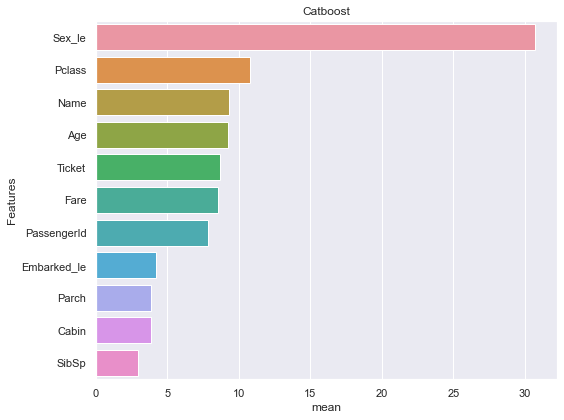

In [118]:
X = df_train_le_enc
ff1=[]
num_splits = 5
importance = []
kfold = KFold(n_splits=num_splits)
for train_index, test_index in kfold.split(X):
    X_train = X.iloc[train_index]
    X_test = X.iloc[test_index]
    y_train = y.iloc[train_index]
    y_test = y.iloc[test_index]
    
    model = CatBoostClassifier(iterations=2000, learning_rate=0.1, depth=8, thread_count=5, use_best_model=True)
    model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=False, use_best_model=True,
             early_stopping_rounds=100)
    
    imp = pd.DataFrame({'Importance': model.feature_importances_, 'Features': X.columns })
    importance.append(imp)
    
tmp_df = pd.merge(importance[0], importance[1], left_on='Features', 
                  right_on='Features')[['Features', 'Importance_x', 'Importance_y']]
for i in range(2, len(importance)):
    tmp_df = pd.merge(tmp_df, importance[i], left_on='Features', 
                      right_on='Features')

tmp_df['mean'] = tmp_df.mean(axis=1)


plt.figure(figsize=(8, 6))
sns.set(font_scale = 1)
sns.barplot(x="mean", y="Features", data=tmp_df.sort_values(by="mean", ascending=False))
plt.title('Catboost')
plt.tight_layout()
plt.show()

#### Although catboost was not selecting sex as an important feature, in kfold crossvalidation, sex became the most important feature. PClass is in the second position.

#### Applying on cleaned data for catboost

In [119]:
df_train_cat.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,3,1,22.0,1,0,7.2500,147,2
1,1,0,38.0,1,0,71.2833,81,0
2,3,0,26.0,0,0,7.9250,147,2
3,1,0,35.0,1,0,53.1000,55,2
4,3,1,35.0,0,0,8.0500,147,2


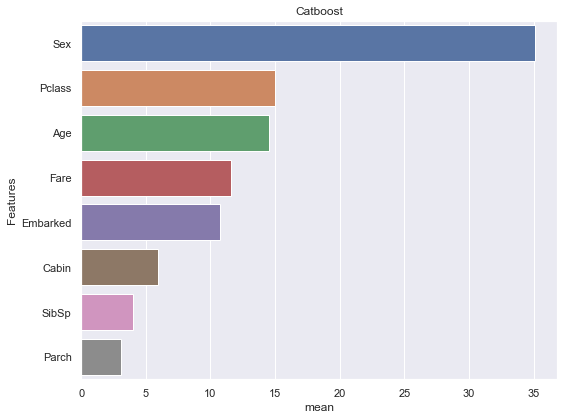

In [120]:
cat_features = ['Sex', 'Cabin', 'Embarked']
X = df_train_cat
ff1=[]
num_splits = 5
importance = []
kfold = KFold(n_splits=num_splits)
for train_index, test_index in kfold.split(X):
    X_train = X.iloc[train_index]
    X_test = X.iloc[test_index]
    y_train = y.iloc[train_index]
    y_test = y.iloc[test_index]
    
    model = CatBoostClassifier(iterations=2000, learning_rate=0.1, depth=8, thread_count=5, use_best_model=True,
                               cat_features=cat_features)
    model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=False, use_best_model=True,
             early_stopping_rounds=100)
    
    imp = pd.DataFrame({'Importance': model.feature_importances_, 'Features': X.columns })
    importance.append(imp)
    
tmp_df = pd.merge(importance[0], importance[1], left_on='Features', 
                  right_on='Features')[['Features', 'Importance_x', 'Importance_y']]
for i in range(2, len(importance)):
    tmp_df = pd.merge(tmp_df, importance[i], left_on='Features', 
                      right_on='Features')

tmp_df['mean'] = tmp_df.mean(axis=1)


plt.figure(figsize=(8, 6))
sns.set(font_scale = 1)
sns.barplot(x="mean", y="Features", data=tmp_df.sort_values(by="mean", ascending=False))
plt.title('Catboost')
plt.tight_layout()
plt.show()

#### Sex, PCalss like XGBoost is among the top features, but catboost chose Age over Cabin. It may due to imputations conducted on 'Age'. Null values in 'Age' were replaced by mean value. 

## Permutation Importance

In [121]:
import eli5
from eli5.sklearn import PermutationImportance

In [122]:
test_size = 0.3
random_state = 2021
X_train, X_test, y_train, y_test = train_test_split(df_train_le_enc, y, test_size=test_size, random_state=random_state)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5)


#### PermutationImportance gets trained model.

In [123]:
lgb = lightgbm.LGBMClassifier(random_state=2020, n_estimators=20000, num_leaves=15, learning_rate=0.011, colsample_bytree=0.9,
                              verbose=1, class_weight='balanced')
lgb.fit(X_train, y_train, eval_set=(X_val, y_val), verbose=1000, early_stopping_rounds=50)
pred = lgb.predict(X_test, num_iteration=lgb.best_iteration_)
print(f1_score(y_test, pred, pos_label=0))
perm = PermutationImportance(lgb, random_state=2020).fit(X_test, y_test)

[LightGBM] [Info] Number of positive: 239, number of negative: 384
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000314 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 867
[LightGBM] [Info] Number of data points in the train set: 623, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[406]	valid_0's binary_logloss: 0.417888
0.8383233532934131


In [124]:
eli5.show_weights(perm, feature_names = X_test.columns.tolist(), top=1)

In [125]:
len(X_test.columns)

11

In [126]:
eli5.show_weights(perm, feature_names = X_test.columns.tolist(), top=11)

Weight,Feature
0.1254 ± 0.0775,Sex_le
0.0313 ± 0.0332,Fare
0.0284 ± 0.0289,Age
0.0194 ± 0.0202,Cabin
0.0164 ± 0.0112,Ticket
0.0164 ± 0.0060,SibSp
0.0134 ± 0.0146,Pclass
0.0090 ± 0.0274,PassengerId
0.0030 ± 0.0073,Parch
0.0015 ± 0.0174,Embarked_le
